# Clustering
*Clustering* is the task of partitioning the dataset into groups, called clusters. The goal is to split up the data in such a way that points within a single cluster are very similar and points in different clusters are different. Similarly to classification algorithms, clustering algorithms assign (or predict) a number to each data point, indicating which cluster a particular point belongs to.

In *scikit-learn*, clustering of unlabeled data can be performed with the module [sklearn.cluster](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster).

Each clustering algorithm in *scikit-learn* comes in two variants: a class, that implements the **fit** method to learn the clusters on train data, and a function, that, given train data, returns an array of integer labels corresponding to the different clusters. For the class, the labels over the training data can be found in the `labels_` attribute.

*Disclaimer*: Much of the code in this notebook was lifted from the excellent book [Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do) by Andreas Muller and Sarah Guido.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# k-Means Clustering
k-means clustering is one of the simplest and most commonly used clustering algorithms. It tries to find *cluster centers* that are representative of certain regions of the data. The algorithm alternates between two steps: assigning each data point to the closest cluster center, and then setting each cluster center as the mean of the data points that are assigned to it. The algorithm is finished when the assignment of instances to clusters no longer changes. The following example illustrates the algorithm on a synthetic dataset:

## Advantages of k-Means Clustering
* Easy to understand
* Runs relatively quickly
* Scales easily to large datasets

## Disadvantages of k-Means Clustering
* Relies on random initialization
* Relatively restrictive assumptions regarding the shape of clusters
* Requirement to specify the number of clusters you are looking for

### k-Means Clustering in scikit-learn
*scikit-learn* implements k-Means in the [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class.

In [2]:
import numbers
from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle as shuffle_

def make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=1.0,
               center_box=(-10.0, 10.0), shuffle=True, random_state=None):
    """Generate isotropic Gaussian blobs for clustering.

    Read more in the :ref:`User Guide <sample_generators>`.

    Parameters
    ----------
    n_samples : int, or tuple, optional (default=100)
        The total number of points equally divided among clusters.

    n_features : int, optional (default=2)
        The number of features for each sample.

    centers : int or array of shape [n_centers, n_features], optional
        (default=3)
        The number of centers to generate, or the fixed center locations.

    cluster_std: float or sequence of floats, optional (default=1.0)
        The standard deviation of the clusters.

    center_box: pair of floats (min, max), optional (default=(-10.0, 10.0))
        The bounding box for each cluster center when centers are
        generated at random.

    shuffle : boolean, optional (default=True)
        Shuffle the samples.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Returns
    -------
    X : array of shape [n_samples, n_features]
        The generated samples.

    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.

    Examples
    --------
    >>> from sklearn.datasets.samples_generator import make_blobs
    >>> X, y = make_blobs(n_samples=10, centers=3, n_features=2,
    ...                   random_state=0)
    >>> print(X.shape)
    (10, 2)
    >>> y
    array([0, 0, 1, 0, 2, 2, 2, 1, 1, 0])

    See also
    --------
    make_classification: a more intricate variant
    """
    generator = check_random_state(random_state)

    if isinstance(centers, numbers.Integral):
        centers = generator.uniform(center_box[0], center_box[1],
                                    size=(centers, n_features))
    else:
        centers = check_array(centers)
        n_features = centers.shape[1]

    if isinstance(cluster_std, numbers.Real):
        cluster_std = np.ones(len(centers)) * cluster_std

    X = []
    y = []

    n_centers = centers.shape[0]
    if isinstance(n_samples, numbers.Integral):
        n_samples_per_center = [int(n_samples // n_centers)] * n_centers
        for i in range(n_samples % n_centers):
            n_samples_per_center[i] += 1
    else:
        n_samples_per_center = n_samples

    for i, (n, std) in enumerate(zip(n_samples_per_center, cluster_std)):
        X.append(centers[i] + generator.normal(scale=std,
                                               size=(n, n_features)))
        y += [i] * n

    X = np.concatenate(X)
    y = np.array(y)

    if shuffle:
        X, y = shuffle_(X, y, random_state=generator)

    return X, y


In [3]:
import matplotlib as mpl
from matplotlib.colors import colorConverter

def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.

    Parameters
    ----------

    x1 : nd-array
        input data, first axis

    x2 : nd-array
        input data, second axis

    y : nd-array
        input data, discrete labels

    cmap : colormap
        Colormap to use.

    markers : list of string
        List of markers to use, or None (which defaults to 'o').

    s : int or float
        Size of the marker

    padding : float
        Fraction of the dataset range to use for padding the axes.

    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

In [4]:
from cycler import cycler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

def plot_kmeans_algorithm():

    X, y = make_blobs(random_state=1)
    # we don't want cyan in there
    with mpl.rc_context(rc={'axes.prop_cycle': cycler('color', ['#0000aa',
                                                                '#ff2020',
                                                                '#50ff50'])}):
        fig, axes = plt.subplots(3, 3, figsize=(10, 8), subplot_kw={'xticks': (), 'yticks': ()})
        axes = axes.ravel()
        axes[0].set_title("Input data")
        discrete_scatter(X[:, 0], X[:, 1], ax=axes[0], markers=['o'], c='w')

        axes[1].set_title("Initialization")
        init = X[:3, :]
        discrete_scatter(X[:, 0], X[:, 1], ax=axes[1], markers=['o'], c='w')
        discrete_scatter(init[:, 0], init[:, 1], [0, 1, 2], ax=axes[1],
                         markers=['^'], markeredgewidth=2)

        axes[2].set_title("Assign Points (1)")
        km = KMeans(n_clusters=3, init=init, max_iter=1, n_init=1).fit(X)
        centers = km.cluster_centers_
        # need to compute labels by hand. scikit-learn does two e-steps for max_iter=1
        # (and it's totally my fault)
        labels = np.argmin(pairwise_distances(init, X), axis=0)
        discrete_scatter(X[:, 0], X[:, 1], labels, markers=['o'],
                         ax=axes[2])
        discrete_scatter(init[:, 0], init[:, 1], [0, 1, 2],
                         ax=axes[2], markers=['^'], markeredgewidth=2)

        axes[3].set_title("Recompute Centers (1)")
        discrete_scatter(X[:, 0], X[:, 1], labels, markers=['o'],
                         ax=axes[3])
        discrete_scatter(centers[:, 0], centers[:, 1], [0, 1, 2],
                         ax=axes[3], markers=['^'], markeredgewidth=2)

        axes[4].set_title("Reassign Points (2)")
        km = KMeans(n_clusters=3, init=init, max_iter=1, n_init=1).fit(X)
        labels = km.labels_
        discrete_scatter(X[:, 0], X[:, 1], labels, markers=['o'],
                         ax=axes[4])
        discrete_scatter(centers[:, 0], centers[:, 1], [0, 1, 2],
                         ax=axes[4], markers=['^'], markeredgewidth=2)

        km = KMeans(n_clusters=3, init=init, max_iter=2, n_init=1).fit(X)
        axes[5].set_title("Recompute Centers (2)")
        centers = km.cluster_centers_
        discrete_scatter(X[:, 0], X[:, 1], labels, markers=['o'],
                         ax=axes[5])
        discrete_scatter(centers[:, 0], centers[:, 1], [0, 1, 2],
                         ax=axes[5], markers=['^'], markeredgewidth=2)

        axes[6].set_title("Reassign Points (3)")
        labels = km.labels_
        discrete_scatter(X[:, 0], X[:, 1], labels, markers=['o'],
                         ax=axes[6])
        markers = discrete_scatter(centers[:, 0], centers[:, 1], [0, 1, 2],
                                   ax=axes[6], markers=['^'],
                                   markeredgewidth=2)

        axes[7].set_title("Recompute Centers (3)")
        km = KMeans(n_clusters=3, init=init, max_iter=3, n_init=1).fit(X)
        centers = km.cluster_centers_
        discrete_scatter(X[:, 0], X[:, 1], labels, markers=['o'],
                         ax=axes[7])
        discrete_scatter(centers[:, 0], centers[:, 1], [0, 1, 2],
                         ax=axes[7], markers=['^'], markeredgewidth=2)
        axes[8].set_axis_off()
        axes[8].legend(markers, ["Cluster 0", "Cluster 1", "Cluster 2"], loc='best')

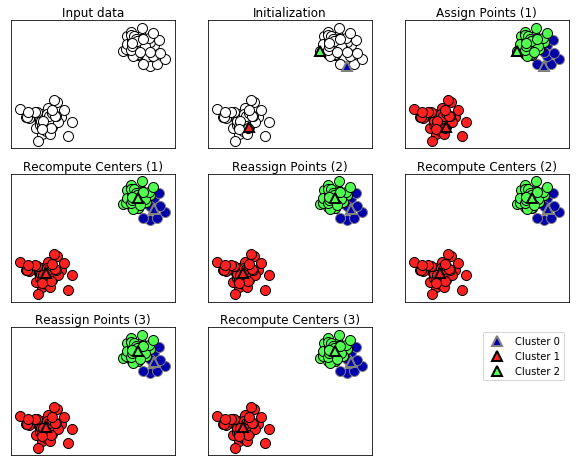

In [5]:
plot_kmeans_algorithm()

Cluster centers are shown as triangles, while data points are shown as circles. Colors indicate cluster membership. We specified that we are looking for three clusters, so the algorithm was initialized by declaring three data points randomly as cluster centers (see “Initialization”). Then the iterative algorithm starts. First, each data point is assigned to the cluster center it is closest to (see “Assign Points (1)”). Next, the cluster centers are updated to be the mean of the assigned points (see “Recompute Centers (1)”). Then the process is repeated two more times. After the third iteration, the assignment of points to cluster centers remained unchanged, so the algorithm stops.

Given new data points, k-means will assign each to the closest cluster center. The next example shows the boundaries of the cluster centers that were learned above:

In [6]:
from matplotlib.colors import ListedColormap
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])

def plot_2d_classification(classifier, X, fill=False, ax=None, eps=None, alpha=1, cm=cm3):
    # multiclass
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    decision_values = classifier.predict(X_grid)
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max,
                                                         y_min, y_max),
              aspect='auto', origin='lower', alpha=alpha, cmap=cm)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [7]:
c = ['#0000aa', '#ff2020', '#50ff50']
def plot_kmeans_boundaries():
    X, y = make_blobs(random_state=1)
    init = X[:3, :]
    km = KMeans(n_clusters=3, init=init, max_iter=2, n_init=1).fit(X)
    discrete_scatter(X[:, 0], X[:, 1], km.labels_, markers=['o'], c=c)
    discrete_scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], [0, 1, 2], markers=['^'], markeredgewidth=2, c=c)
    plot_2d_classification(km, X, cm=cm3, alpha=.4)

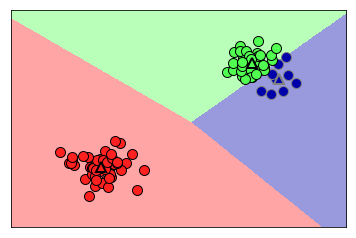

In [8]:
plot_kmeans_boundaries()

Applying k-means with *scikit-learn* is quite straightforward. Here, we apply it to the synthetic data that we used for the preceding plots. We instantiate the KMeans class, and set the number of clusters we are looking for. Then we call the **fit** method with the data:

In [9]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# generate synthetic two-dimensional data
X, y = make_blobs(random_state=1)

# build the clustering model
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

During the algorithm, each training data point in X is assigned a cluster label. You can find these labels in the `kmeans.labels_` attribute:

In [10]:
print("Cluster memberships:\n{}".format(kmeans.labels_))

Cluster memberships:
[1 2 2 2 0 0 0 2 1 1 2 2 0 1 0 0 0 1 2 2 0 2 0 1 2 0 0 1 1 0 1 1 0 1 2 0 2
 2 2 0 0 2 1 2 2 0 1 1 1 1 2 0 0 0 1 0 2 2 1 1 2 0 0 2 2 0 1 0 1 2 2 2 0 1
 1 2 0 0 1 2 1 2 2 0 1 1 1 1 2 1 0 1 1 2 2 0 0 1 0 1]


As we asked for three clusters, the clusters are numbered 0 to 2.

You can also assign cluster labels to new points, using the **predict** method. Each new point is assigned to the closest cluster center when predicting, but the existing model is not changed. Running **predict** on the training set returns the same result as `labels_`:

In [11]:
print(kmeans.predict(X))

[1 2 2 2 0 0 0 2 1 1 2 2 0 1 0 0 0 1 2 2 0 2 0 1 2 0 0 1 1 0 1 1 0 1 2 0 2
 2 2 0 0 2 1 2 2 0 1 1 1 1 2 0 0 0 1 0 2 2 1 1 2 0 0 2 2 0 1 0 1 2 2 2 0 1
 1 2 0 0 1 2 1 2 2 0 1 1 1 1 2 1 0 1 1 2 2 0 0 1 0 1]


You can see that clustering is somewhat similar to classification, in that each item gets a label. However, there is no ground truth, and consequently the labels themselves have no a priori meaning. Let’s go back to the example of clustering face images that we discussed before. It might be that the cluster 3 found by the algorithm contains only faces of your friend Alice. You can only know that after you look at the pictures, though, and the number 3 is arbitrary. The only information the algorithm gives you is that all faces labeled as 3 are similar.

For the clustering we just computed on the two-dimensional toy dataset, that means that we should not assign any significance to the fact that one group was labeled 0 and another one was labeled 1. Running the algorithm again might result in a different numbering of clusters because of the random nature of the initialization.

Here is a plot of this data again. The cluster centers are stored in the `cluster_centers_` attribute, and we plot them as triangles:

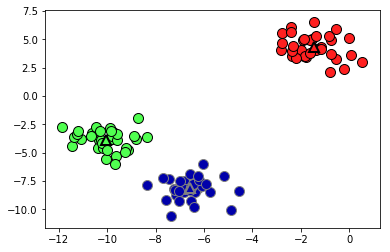

In [12]:
discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers='o', c=c)
discrete_scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers='^', markeredgewidth=2, c=c)

We can also use more or fewer cluster centers:

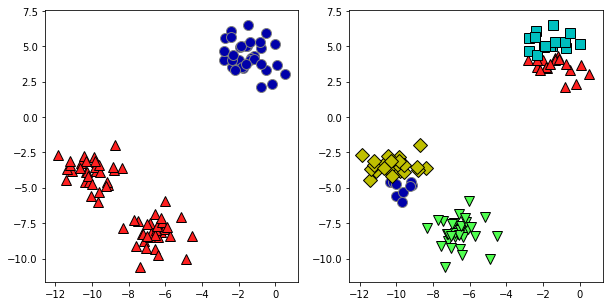

In [13]:
c5 = ['#0000aa', '#ff2020', '#50ff50', 'y', 'c']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# using two cluster centers:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
assignments = kmeans.labels_

discrete_scatter(X[:, 0], X[:, 1], assignments, ax=axes[0], c=c)

# using five cluster centers:
kmeans = KMeans(n_clusters=5)

kmeans.fit(X)
assignments = kmeans.labels_

discrete_scatter(X[:, 0], X[:, 1], assignments, ax=axes[1], c=c5)

### Failure cases of k-means
Even if you know the “right” number of clusters for a given dataset, k-means might not always be able to recover them. Each cluster is defined solely by its center, which means that each cluster is a convex shape. As a result of this, k-means can only capture relatively simple shapes. k-means also assumes that all clusters have the same “diameter” in some sense; it always draws the boundary between clusters to be exactly in the middle between the cluster centers. That can sometimes lead to surprising results, as shown below:

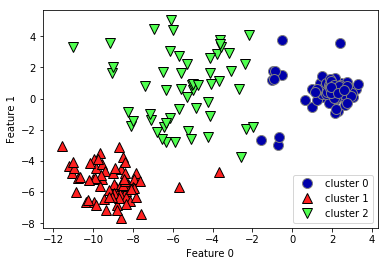

In [14]:
X_varied, y_varied = make_blobs(n_samples=200,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=170)
y_pred = KMeans(n_clusters=3, random_state=0).fit_predict(X_varied)

discrete_scatter(X_varied[:, 0], X_varied[:, 1], y_pred, c=c)
plt.legend(["cluster 0", "cluster 1", "cluster 2"], loc='best')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

One might have expected the dense region in the lower left to be the first cluster, the dense region in the upper right to be the second, and the less dense region in the center to be the third. Instead, both cluster 0 and cluster 1 have some points that are far away from all the other points in these clusters that “reach” toward the center.

k-means also assumes that all directions are equally important for each cluster. The following plot shows a two-dimensional dataset where there are three clearly separated parts in the data. However, these groups are stretched toward the diagonal. As k-means only considers the distance to the nearest cluster center, it can’t handle this kind of data:

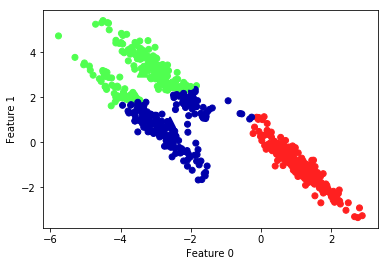

In [15]:
# generate some random cluster data
X, y = make_blobs(random_state=170, n_samples=600)
rng = np.random.RandomState(74)

# transform the data to be stretched
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)

# cluster the data into three clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_pred = kmeans.predict(X)

# plot the cluster assignments and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=cm3)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='^', c=[0, 1, 2], s=100, linewidth=2, cmap=cm3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

k-means also performs poorly if the clusters have more complex shapes, like the two_moons data we encountered previously:

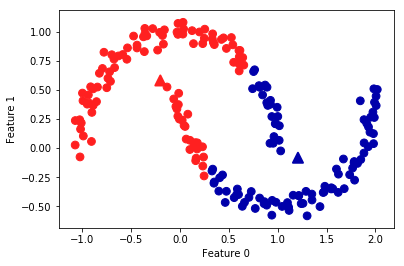

In [16]:
cm2 = ListedColormap(['#0000aa', '#ff2020'])

# generate synthetic two_moons data (with less noise this time)
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# cluster the data into two clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_pred = kmeans.predict(X)

# plot the cluster assignments and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=cm2, s=60)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='^', c=[cm2(0), cm2(1)], s=100, linewidth=2)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Here, we would hope that the clustering algorithm can discover the two half-moon shapes. However, this is not possible using the k-means algorithm.

### k-means Summary
k-means is a very popular algorithm for clustering, not only because it is relatively easy to understand and implement, but also because it runs relatively quickly. k-means scales easily to large datasets, and *scikit-learn* even includes a more scalable variant in the **MiniBatchKMeans** class, which can handle very large datasets.

One of the drawbacks of k-means is that it relies on a random initialization, which means the outcome of the algorithm depends on a random seed. By default, *scikit-learn* runs the algorithm 10 times with 10 different random initializations, and returns the best result. Further downsides of k-means are the relatively restrictive assumptions made on the shape of clusters, and the requirement to specify the number of clusters you are looking for (which might not be known in a real-world application).

# Agglomerative Clustering
*Agglomerative clustering* refers to a collection of clustering algorithms that all build upon the same principles: the algorithm starts by declaring each point its own cluster, and then merges the two most similar clusters until some stopping criterion is satisfied. The stopping criterion implemented in *scikit-learn* is the number of clusters, so similar clusters are merged until only the specified number of clusters are left. There are several *linkage* criteria that specify how exactly the “most similar cluster” is measured. This measure is always defined between two existing clusters.

The following three choices for *linkage* are implemented in *scikit-learn*:
* **ward**
    * The default choice, ward picks the two clusters to merge such that the variance within all clusters increases the least. This often leads to clusters that are relatively equally sized.
* **average**
    * average linkage merges the two clusters that have the smallest average distance between all their points.
* **complete**
    * complete linkage (also known as maximum linkage) merges the two clusters that have the smallest maximum distance between their points.
    
**ward** works on most datasets, and we will use it in our examples. If the clusters have very dissimilar numbers of members (if one is much bigger than all the others, for example), **average** or **complete** might work better.

## Advantages of Agglomerative Clustering
* The hierarchy of clusters can be represented as a tree (or *dendrogram*)
* Can scale to large number of samples when it is used jointly with a connectivity matrix
* Makes fewer assumptions regarding the shape of clusters than k-Means

## Disadvantages of Agglomerative Clustering
* Computationally expensive when no connectivity constraints are added between samples
    * It considers at each step all the possible merges.
* Cannot make predictions regarding new data points
* Requirement to specify the number of clusters you are looking for

### Agglomerative Clustering in scikit-learn
*scikit-learn* implements Agglomerative Clustering in the [AgglomerativeClustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) class.

The following plot illustrates the progression of agglomerative clustering on a two-dimensional dataset, looking for three clusters:

In [17]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity

def plot_agglomerative_algorithm():
    # generate synthetic two-dimensional data
    X, y = make_blobs(random_state=0, n_samples=12)

    agg = AgglomerativeClustering(n_clusters=X.shape[0], compute_full_tree=True).fit(X)

    fig, axes = plt.subplots(X.shape[0] // 5, 5, subplot_kw={'xticks': (),
                                                             'yticks': ()},
                             figsize=(20, 8))

    eps = X.std() / 2

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    gridpoints = np.c_[xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)]

    for i, ax in enumerate(axes.ravel()):
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        agg.n_clusters = X.shape[0] - i
        agg.fit(X)
        ax.set_title("Step %d" % i)
        ax.scatter(X[:, 0], X[:, 1], s=60, c='grey')
        bins = np.bincount(agg.labels_)
        for cluster in range(agg.n_clusters):
            if bins[cluster] > 1:
                points = X[agg.labels_ == cluster]
                other_points = X[agg.labels_ != cluster]

                kde = KernelDensity(bandwidth=.5).fit(points)
                scores = kde.score_samples(gridpoints)
                score_inside = np.min(kde.score_samples(points))
                score_outside = np.max(kde.score_samples(other_points))
                levels = .8 * score_inside + .2 * score_outside
                ax.contour(xx, yy, scores.reshape(100, 100), levels=[levels],
                           colors='k', linestyles='solid', linewidths=2)

    axes[0, 0].set_title("Initialization")

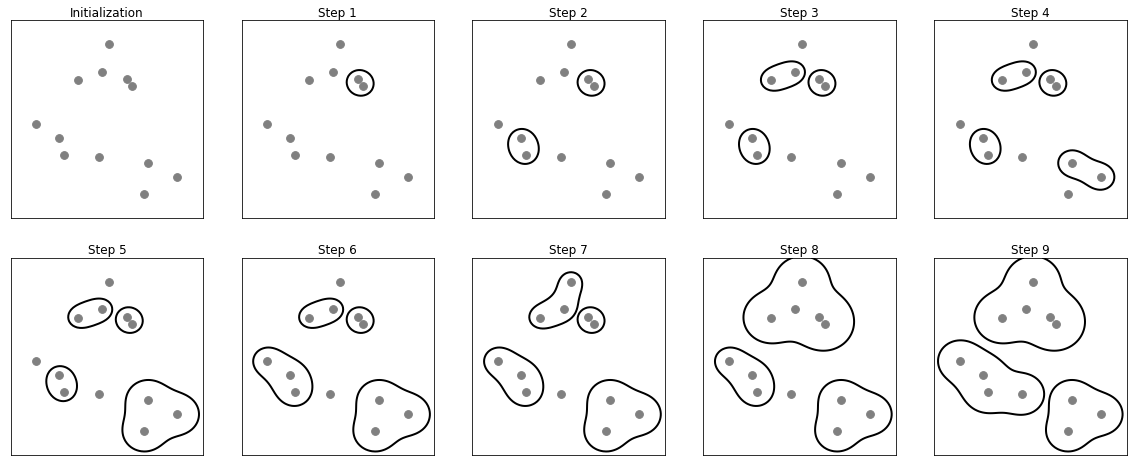

In [18]:
plot_agglomerative_algorithm()

Initially, each point is its own cluster. Then, in each step, the two clusters that are closest are merged. In the first four steps, two single-point clusters are picked and these are joined into two-point clusters. In step 5, one of the two-point clusters is extended to a third point, and so on. In step 9, there are only three clusters remaining. As we specified that we are looking for three clusters, the algorithm then stops.

Let’s have a look at how agglomerative clustering performs on the simple three-cluster data we used here. Because of the way the algorithm works, agglomerative clustering cannot make predictions for new data points. Therefore, **AgglomerativeClustering** has no **predict** method. To build the model and get the cluster memberships on the training set, use the **fit_predict** method instead. The result is shown below:

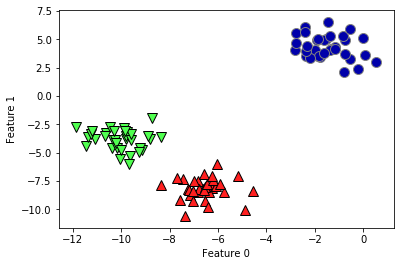

In [19]:
from sklearn.cluster import AgglomerativeClustering
X, y = make_blobs(random_state=1)

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X)

discrete_scatter(X[:, 0], X[:, 1], assignment, c=c)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

As expected, the algorithm recovers the clustering perfectly. While the *scikit-learn* implementation of agglomerative clustering requires you to specify the number of clusters you want the algorithm to find, agglomerative clustering methods provide some help with choosing the right number, which we will discuss next.

### Hierarchal clustering and dendrograms
Agglomerative clustering produces what is known as a *hierarchical clustering*. The clustering proceeds iteratively, and every point makes a journey from being a single point cluster to belonging to some final cluster. Each intermediate step provides a clustering of the data (with a different number of clusters). It is sometimes helpful to look at all possible clusterings jointly. The next example shows an overlay of all the possible clusterings shown in above, providing some insight into how each cluster breaks up into smaller clusters:

In [20]:
def plot_agglomerative():
    X, y = make_blobs(random_state=0, n_samples=12)
    agg = AgglomerativeClustering(n_clusters=3)

    eps = X.std() / 2.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    gridpoints = np.c_[xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)]

    ax = plt.gca()
    for i, x in enumerate(X):
        ax.text(x[0] + .1, x[1], "%d" % i, horizontalalignment='left', verticalalignment='center')

    ax.scatter(X[:, 0], X[:, 1], s=60, c='grey')
    ax.set_xticks(())
    ax.set_yticks(())

    for i in range(11):
        agg.n_clusters = X.shape[0] - i
        agg.fit(X)

        bins = np.bincount(agg.labels_)
        for cluster in range(agg.n_clusters):
            if bins[cluster] > 1:
                points = X[agg.labels_ == cluster]
                other_points = X[agg.labels_ != cluster]

                kde = KernelDensity(bandwidth=.5).fit(points)
                scores = kde.score_samples(gridpoints)
                score_inside = np.min(kde.score_samples(points))
                score_outside = np.max(kde.score_samples(other_points))
                levels = .8 * score_inside + .2 * score_outside
                ax.contour(xx, yy, scores.reshape(100, 100), levels=[levels],
                           colors='k', linestyles='solid', linewidths=1)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

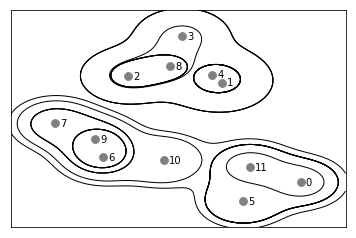

In [21]:
plot_agglomerative()

While this visualization provides a very detailed view of the hierarchical clustering, it relies on the two-dimensional nature of the data and therefore cannot be used on datasets that have more than two features. There is, however, another tool to visualize hierarchical clustering, called a *dendrogram*, that can handle multidimensional datasets.

Unfortunately, *scikit-learn* currently does not have the functionality to draw dendrograms. However, you can generate them easily using *SciPy*. The *SciPy* clustering algorithms have a slightly different interface to the *scikit-learn* clustering algorithms. *SciPy* provides a function that takes a data array X and computes a *linkage array*, which encodes hierarchical cluster similarities. We can then feed this linkage array into the *scipy* **dendrogram** function to plot the dendrogram:

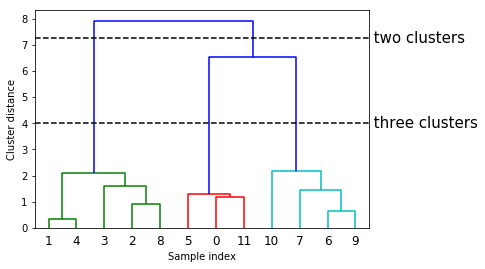

In [22]:
# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

X, y = make_blobs(random_state=0, n_samples=12)
# Apply the ward clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# bridged when performing agglomerative clustering
linkage_array = ward(X)
# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

# Mark the cuts in the tree that signify two or three clusters
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')

ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size': 15})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

The dendrogram shows data points as points on the bottom (numbered from 0 to 11). Then, a tree is plotted with these points (representing single-point clusters) as the leaves, and a new node parent is added for each two clusters that are joined.
Reading from bottom to top, the data points 1 and 4 are joined first (as you could see in the time-series agglomeration plot above). Next, points 6 and 9 are joined into a cluster, and so on. At the top level, there are two branches, one consisting of points 11, 0, 5, 10, 7, 6, and 9, and the other consisting of points 1, 4, 3, 2, and 8. These correspond to the two largest clusters in the lefthand side of the plot.

The y-axis in the dendrogram doesn’t just specify when in the agglomerative algorithm two clusters get merged. The length of each branch also shows how far apart the merged clusters are. The longest branches in this dendrogram are the three lines that are marked by the dashed line labeled “three clusters.” That these are the longest branches indicates that going from three to two clusters meant merging some very far-apart points. We see this again at the top of the chart, where merging the two remaining clusters into a single cluster again bridges a relatively large distance.

Unfortunately, agglomerative clustering still fails much of the time at separating complex shapes like the *two_moons* dataset.

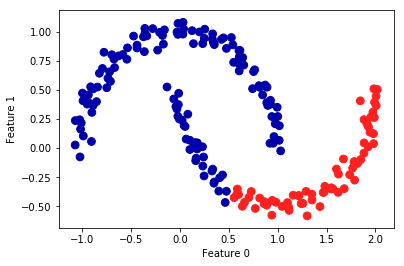

In [23]:
# generate synthetic two_moons data (with less noise this time)
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# cluster the data into two clusters
agg = AgglomerativeClustering(n_clusters=2)
agg.fit(X)
assignment = agg.fit_predict(X)

# plot the cluster assignments and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=assignment, cmap=cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# DBSCAN
Another very useful clustering algorithm is DBSCAN (which stands for “density-based spatial clustering of applications with noise”). The main benefits of DBSCAN are that it does not require the user to set the number of clusters *a priori*, it can capture clusters of complex shapes, and it can identify points that are not part of any cluster. DBSCAN is somewhat slower than agglomerative clustering and k-means, but still scales to relatively large datasets.

DBSCAN works by identifying points that are in “crowded” regions of the feature space, where many data points are close together. These regions are referred to as *dense* regions in feature space. The idea behind DBSCAN is that clusters form dense regions of data, separated by regions that are relatively empty.

Points that are within a dense region are called *core samples* (or core points), and they are defined as follows. There are two parameters in DBSCAN: **min_samples** and **eps**. If there are at least **min_samples** many data points within a distance of **eps** to a given data point, that data point is classified as a core sample. Core samples that are closer to each other than the distance **eps** are put into the same cluster by DBSCAN.

The algorithm works by picking an arbitrary point to start with. It then finds all points with distance **eps** or less from that point. If there are less than **min_samples** points within distance **eps** of the starting point, this point is labeled as *noise*, meaning that it doesn’t belong to any cluster. If there are more than **min_samples** points within a distance of **eps**, the point is labeled a core sample and assigned a new cluster label. Then, all neighbors (within **eps**) of the point are visited. If they have not been assigned a cluster yet, they are assigned the new cluster label that was just created. If they are core samples, their neighbors are visited in turn, and so on. The cluster grows until there are no more core samples within distance **eps** of the cluster. Then another point that hasn’t yet been visited is picked, and the same procedure is repeated.

In the end, there are three kinds of points: core points, points that are within distance **eps** of core points (called *boundary points*), and noise. When the DBSCAN algorithm is run on a particular dataset multiple times, the clustering of the core points is always the same, and the same points will always be labeled as noise. However, a boundary point might be neighbor to core samples of more than one cluster. Therefore, the cluster membership of boundary points depends on the order in which points are visited. Usually there are only few boundary points, and this slight dependence on the order of points is not important.

## Advantages of DBSCAN
* Does not require the user to set the number of clusters
* It can capture clusters of complex shapes
* It can identify points which are not part of any cluster

## Disadvantages of DBSCAN
* Somewhat slower than agglomerative clustering and significantly slower than k-Means
    * But can still scale to relatively large datasets
* Cannot make predictions regarding new data points
* Can require a good deal of parameter tweaking for **min_samples** and **eps** in order to get good clustering

### DBSCAN in scikit-learn
*scikit-learn* implements DBSCAN in the [DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) class.

Let’s apply DBSCAN on the synthetic dataset we used to demonstrate agglomerative clustering. Like agglomerative clustering, DBSCAN does not allow predictions on new test data, so we will use the **fit_predict** method to perform clustering and return the cluster labels in one step:

In [24]:
from sklearn.cluster import DBSCAN
X, y = make_blobs(random_state=0, n_samples=12)

dbscan = DBSCAN()
clusters = dbscan.fit_predict(X)
print("Cluster memberships:\n{}".format(clusters))

Cluster memberships:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


As you can see, all data points were assigned the label -1, which stands for noise. This is a consequence of the default parameter settings for **eps** and **min_samples**, which are not tuned for small toy datasets. The cluster assignments for different values of **min_samples** and **eps** are shown below:

In [25]:
def plot_dbscan():
    X, y = make_blobs(random_state=0, n_samples=12)

    dbscan = DBSCAN()
    clusters = dbscan.fit_predict(X)
    clusters

    fig, axes = plt.subplots(3, 4, figsize=(11, 8), subplot_kw={'xticks': (), 'yticks': ()})
    # Plot clusters as red, green and blue, and outliers (-1) as white
    colors = ['r', 'g', 'b']
    markers = ['o', '^', 'v']

    # iterate over settings of min_samples and eps
    for i, min_samples in enumerate([2, 3, 5]):
        for j, eps in enumerate([1, 1.5, 2, 3]):
            # instantiate DBSCAN with a particular setting
            dbscan = DBSCAN(min_samples=min_samples, eps=eps)
            # get cluster assignments
            clusters = dbscan.fit_predict(X)
            print("min_samples: %d eps: %f  cluster: %s" % (min_samples, eps, clusters))
            if np.any(clusters == -1):
                c = ['w'] + colors
                m = ['o'] + markers
            else:
                c = colors
                m = markers
            discrete_scatter(X[:, 0], X[:, 1], clusters, ax=axes[i, j], c=c, s=8, markers=m)
            inds = dbscan.core_sample_indices_
            # vizualize core samples and clusters.
            if len(inds):
                discrete_scatter(X[inds, 0], X[inds, 1], clusters[inds],
                                 ax=axes[i, j], s=15, c=colors,
                                 markers=markers)
            axes[i, j].set_title("min_samples: %d eps: %.1f" % (min_samples, eps))
    fig.tight_layout()

min_samples: 2 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 2 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 2 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 2 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 3 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 3 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 3 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 3 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 5 eps: 1.000000  cluster: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
min_samples: 5 eps: 1.500000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 2.000000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]


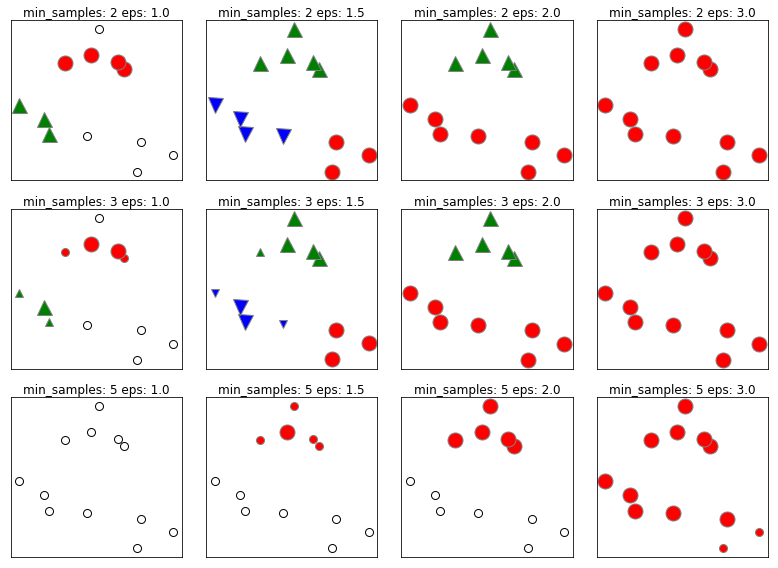

In [26]:
plot_dbscan()

In this plot, points that belong to clusters are solid, while the noise points are shown in white. Core samples are shown as large markers, while boundary points are displayed as smaller markers.

Increasing **eps** (going from left to right in the figure) means that more points will be included in a cluster. This makes clusters grow, but might also lead to multiple clusters joining into one. Increasing **min_samples** (going from top to bottom in the figure) means that fewer points will be core points, and more points will be labeled as noise.
The parameter **eps** is somewhat more important, as it determines what it means for points to be “close.” Setting **eps** to be very small will mean that no points are core samples, and may lead to all points being labeled as noise. Setting **eps** to be very large will result in all points forming a single cluster.

The **min_samples** setting mostly determines whether points in less dense regions will be labeled as outliers or as their own clusters. If you decrease **min_samples**, anything that would have been a cluster with less than **min_samples** many samples will now be labeled as noise. **min_samples** therefore determines the minimum cluster size. You can see this very clearly in in the figure above, when going from **min_samples**=3 to **min_samples**=5 with **eps**=1.5. With **min_samples**=3, there are three clusters: one of four points, one of five points, and one of three points. Using **min_samples**=5, the two smaller clusters (with three and four points) are now labeled as noise, and only the cluster with five samples remains.

While DBSCAN doesn’t require setting the number of clusters explicitly, setting **eps** implicitly controls how many clusters will be found. Finding a good setting for **eps** is sometimes easier after scaling the data using **StandardScaler** or **MinMaxScaler**, as using these scaling techniques will ensure that all features have similar ranges.
The figure below shows the result of running DBSCAN on the two_moons dataset. The algorithm actually finds the two half-circles and separates them using the default settings:

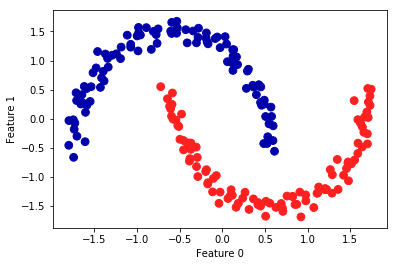

In [27]:
from sklearn.preprocessing import StandardScaler
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_scaled)

# plot the cluster assignments
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

As the algorithm produced the desired number of clusters (two), the parameter settings seem to work well. If we decrease **eps** to 0.2 (from the default of 0.5), we will get eight clusters, which is clearly too many. Increasing **eps** to 0.7 results in a single cluster.

When using DBSCAN, you need to be careful about handling the returned cluster assignments. The use of -1 to indicate noise might result in unexpected effects when using the cluster labels to index another array.

# HDBSCAN
HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications with Noise. Performs DBSCAN over varying epsilon values and integrates the result to find a clustering that gives the best stability over epsilon. This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN), and be more robust to parameter selection.

In practice this means that HDBSCAN returns a good clustering straight away with little or no parameter tuning – and the primary parameter, minimum cluster size, is intuitive and easy to select.

HDBSCAN is ideal for exploratory data analysis; it’s a fast and robust algorithm that you can trust to return meaningful clusters (if there are any).

Essentially HDBSCAN is performing automatic hyperparameter optimization to select the best **eps** for DBSCAN.

## Advantages of DBSCAN
* Does not require the user to set the number of clusters
* Does not require the user to spend time tweaking the **eps** parameter to get good clustering
    * In practice, HDBSCAN just works and returns a good clustering with little or no parameter tuning
* It can capture clusters of complex shapes
* It can identify points which are not part of any cluster

## Disadvantages of DBSCAN
* Slower than any of the other clustering algorithms presented
* Cannot make predictions regarding new data points

### Installing HDBSCAN
HDBSCAN is a separate package which isn't part of *scikit-learn*.  The easiest way to install it is via Anaconda:

    conda install -c conda-forge hdbscan

Let’s apply HDBSCAN on the synthetic dataset we used first used to demonstrate DBSCAN and which required a good bit of parameter tuning with DBSCAN:

In [30]:
from hdbscan import HDBSCAN
X, y = make_blobs(random_state=0, n_samples=12)

hdbscan = HDBSCAN(min_cluster_size=3)
clusters = hdbscan.fit_predict(X)
print("Cluster memberships:\n{}".format(clusters))

Cluster memberships:
[-1  1  1  1  1  0  0  0  1  0  0  0]


# Comparing and Evaluating Clustering Algorithms
One of the challenges in applying clustering algorithms is that it is very hard to assess how well an algorithm worked, and to compare outcomes between different algorithms. After talking about the algorithms behind k-means, agglomerative clustering, and DBSCAN, we will now compare them on some real-world datasets.

## Evaluating clustering with ground truth
There are metrics that can be used to assess the outcome of a clustering algorithm relative to a ground truth clustering, the most important ones being the *adjusted rand index* (ARI) and *normalized mutual information* (NMI), which both provide a quantitative measure between 0 and 1.

Here, we compare the k-means, agglomerative clustering, and DBSCAN algorithms using ARI. We also include what it looks like when we randomly assign points to two clusters for comparison:

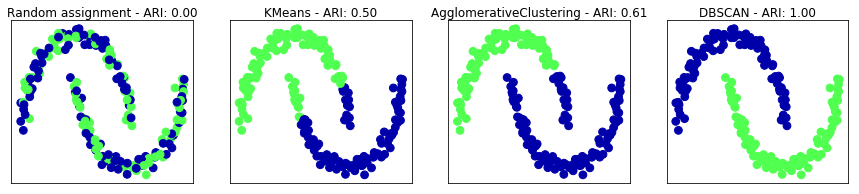

In [40]:
from sklearn.metrics.cluster import adjusted_rand_score
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
               cmap=cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y, clusters)))

The adjusted rand index provides intuitive results, with a random cluster assignment having a score of 0 and DBSCAN (which recovers the desired clustering perfectly) having a score of 1.

A common mistake when evaluating clustering in this way is to use **accuracy_score** instead of **adjusted_rand_score**, **normalized_mutual_info_score**, or some other clustering metric. The problem in using accuracy is that it requires the assigned cluster labels to exactly match the ground truth. However, the cluster labels themselves are meaningless—the only thing that matters is which points are in the same cluster:

In [44]:
from sklearn.metrics import accuracy_score

# these two labelings of points correspond to the same clustering
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]
# accuracy is zero, as none of the labels are the same
print("Accuracy: {:.2f}".format(accuracy_score(clusters1, clusters2)))
# adjusted rand score is 1, as the clustering is exactly the same
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

Accuracy: 0.00
ARI: 1.00


## Evaluating clustering without ground truth
Although we have just shown one way to evaluate clustering algorithms, in practice, there is a big problem with using measures like ARI. When applying clustering algorithms, there is usually no ground truth to which to compare the results. If we knew the right clustering of the data, we could use this information to build a supervised model like a classifier. Therefore, using metrics like ARI and NMI usually only helps in developing algorithms, not in assessing success in an application.

There are scoring metrics for clustering that don’t require ground truth, like the *silhouette coefficient*. However, these often don’t work well in practice. The silhouette score computes the compactness of a cluster, where higher is better, with a perfect score of 1. While compact clusters are good, compactness doesn’t allow for complex shapes.

Here is an example comparing the outcome of k-means, agglomerative clustering, and DBSCAN on the two-moons dataset using the silhouette score:

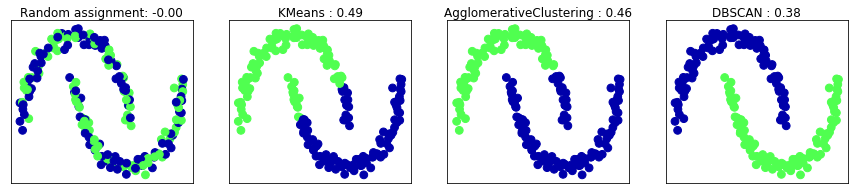

In [43]:
from sklearn.metrics.cluster import silhouette_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=cm3, s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__, silhouette_score(X_scaled, clusters)))

As you can see, k-means gets the highest silhouette score, even though we might prefer the result produced by DBSCAN. A slightly better strategy for evaluating clusters is using *robustness-based* clustering metrics. These run an algorithm after adding some noise to the data, or using different parameter settings, and compare the outcomes. The idea is that if many algorithm parameters and many perturbations of the data return the same result, it is likely to be trustworthy. Unfortunately, this strategy is not implemented in *scikit-learn* at the time of writing.

Even if we get a very robust clustering, or a very high silhouette score, we still don’t know if there is any semantic meaning in the clustering, or whether the clustering reflects an aspect of the data that we are interested in. We hope to find groups of similar data points. Let’s say we cluster the data into two clusters, and all algorithms agree about which points should be clustered together. We still don’t know if the clusters that are found correspond in any way to the concepts we are interested in. It could be that they found something totally different than we were hoping for. The only way to know whether the clustering corresponds to anything we are interested in is to analyze the clusters manually.